### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import tensorflow as tf

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
#tf.compat.v1.disable_eager_execution()
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


In [ ]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
#   try:
#        # Restrict TensorFlow to only use the fourth GPU
#        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')#

#        # Currently, memory growth needs to be the same across GPUs
#        for gpu in gpus:
#            tf.config.experimental.set_memory_growth(gpu, True)
#        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
#        print(e)

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Tracking the state-action pairs for checking convergence


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [16]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01  
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]
        
    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
                # Write your code from here
                # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
                
                # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
                #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])
    #Defining a function to save the Q-dictionary as a pickle file
    def save(self, name):
        with open(name + '.pkl', 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [17]:
Episodes = 2000
episode_time = 24*30 #30 days before which car has to be recharged
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

#Calling the Agent Code
agent = DQNAgent(action_size=action_size, state_size=state_size)

# Invoke agent class
# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [18]:
start_time = time.time()
score_tracked = []
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    terminal_state = False
    score = 0
    track_reward = False
    
    env = CabDriver()
    action_space, state_space, state = env.reset()
    initial_state = env.state_init
    total_time = 0 
    
    while not terminal_state:
        possible_actions_indices, actions = env.requests(state)
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state, possible_actions_indices,actions)
        # 2. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        if (total_time > episode_time):
            terminal_state = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, terminal_state)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
   

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode_number {0}, reward {1}, memory_length {2}, epsilon_value {3} total_time {4}".format(episode,score,len(agent.memory),agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights")
        
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
episode_number 9, reward -174.0, memory_length 1369, epsilon_value 0.9559879218582816 total_time 721.0
episode_number 19, reward 67.0, memory_length 2000, epsilon_value 0.9093638407388868 total_time 722.0
episode_number 29, reward -440.0, memory_length 2000, epsilon_value 0.8650136428878102 total_time 724.0
episode_number 39, reward 159.0, memory_length 2000, epsilon_value 0.8228264297094379 total_time 729.0
episode_number 49, reward -36.0, memory_length 2000, epsilon_value 0.7826967111964858 total_time 725.0
episode_number 59, reward -17.0, memory_length 2000, epsilon_value 0.7445241421500348 total_time 723.0
episode_number 69, reward 478.0, memory_length 2000, epsilon_value 0.7082132712642654 total_time 726.0
episode_number 79, reward 1.0, memory_length 2000, epsilon_value 0.6736733024484752 total_time 723.0
episode_number 89, reward 393.0, memory_length 2000, epsilon_value 0.6408178677895584 total_time 732.0
episode_number 99, reward 162.0, memory_length 2000, epsilon

episode_number 789, reward 1424.0, memory_length 2000, epsilon_value 0.019351022857513896 total_time 727.0
episode_number 799, reward 1702.0, memory_length 2000, epsilon_value 0.01840726233625311 total_time 723.0
episode_number 809, reward 1512.0, memory_length 2000, epsilon_value 0.017509529558747718 total_time 727.0
episode_number 819, reward 1776.0, memory_length 2000, epsilon_value 0.016655579725445836 total_time 721.0
episode_number 829, reward 1238.0, memory_length 2000, epsilon_value 0.015843277516961587 total_time 733.0
episode_number 839, reward 1304.0, memory_length 2000, epsilon_value 0.015070591754664478 total_time 723.0
episode_number 849, reward 1373.0, memory_length 2000, epsilon_value 0.0143355903216747 total_time 723.0
episode_number 859, reward 1569.0, memory_length 2000, epsilon_value 0.013636435331564632 total_time 731.0
episode_number 869, reward 1415.0, memory_length 2000, epsilon_value 0.012971378532685431 total_time 724.0
episode_number 879, reward 1746.0, memor

episode_number 1549, reward 1419.0, memory_length 2000, epsilon_value 0.0004328973175288891 total_time 726.0
episode_number 1559, reward 1334.0, memory_length 2000, epsilon_value 0.00041178466622090814 total_time 722.0
episode_number 1569, reward 1202.0, memory_length 2000, epsilon_value 0.00039170169106753306 total_time 732.0
episode_number 1579, reward 1206.0, memory_length 2000, epsilon_value 0.0003725981741701257 total_time 726.0
episode_number 1589, reward 1517.0, memory_length 2000, epsilon_value 0.0003544263467858655 total_time 722.0
episode_number 1599, reward 1500.0, memory_length 2000, epsilon_value 0.0003371407698810094 total_time 724.0
episode_number 1609, reward 1406.0, memory_length 2000, epsilon_value 0.0003206982205096403 total_time 722.0
episode_number 1619, reward 1378.0, memory_length 2000, epsilon_value 0.00030505758373378805 total_time 722.0
episode_number 1629, reward 1405.0, memory_length 2000, epsilon_value 0.0002901797498146699 total_time 729.0
episode_number 1

In [19]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

In [15]:
(agent.states_tracked)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 989.15784,
 319.96228,
 363.19742,
 444.54843,
 394.11743,
 404.36868,
 448.91238,
 473.12177,
 546.9925,
 481.06638,
 628.976,
 469.48135,
 606.10815,
 526.27655,
 566.3813,
 584.1031,
 625.97205,
 630.1738,
 563.32477,
 588.1229,
 644.03,
 608.5268,
 563.0001,
 564.6192,
 549.1849,
 592.43134,
 554.4323,
 635.24255,
 640.9191,
 552.7162,
 560.1297,
 594.7102,
 567.2129,
 693.3891,
 628.0896,
 594.24005,
 573.35565,
 581.1461,
 570.0726,
 601.4561,
 570.2316,
 595.34033,
 602.0321,
 646.9609,
 687.57367,
 609.08716,
 682.78534,
 633.20734,
 618.0928,
 623.2434,
 582.31116,
 623.77136,
 583.7517,
 611.2906,
 613.91974,
 581.3398,
 623.4187,
 583.9307,
 591.99,
 590.2499,
 619.8054,
 593.5956,
 566.2525,
 618.4021,
 615.969,
 597.4417,
 612.8354,
 630.8511,
 680.79974,
 628.28174,
 661.1688,
 698.4935,
 599.13904,
 612.7567,
 579.6215,
 669.47906,
 599.6315,
 581.4769,
 591.496,
 567.88605,
 597.67926,
 607.53357,
 602.3269,
 

### Tracking Convergence

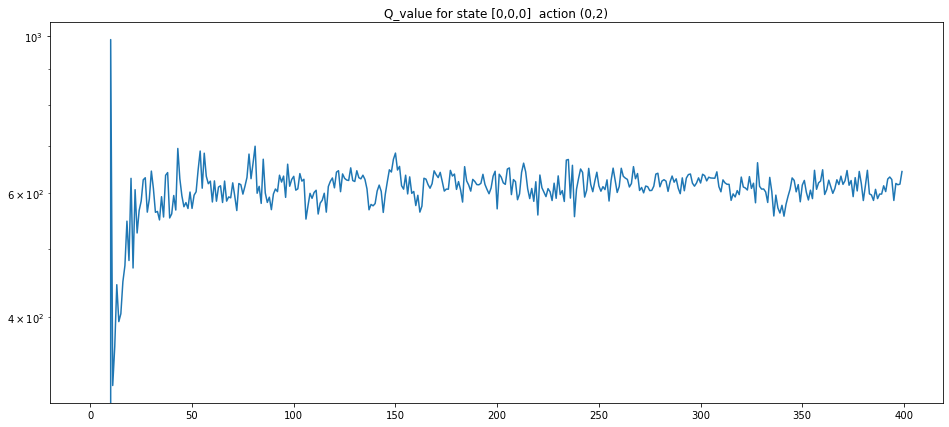

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [12]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

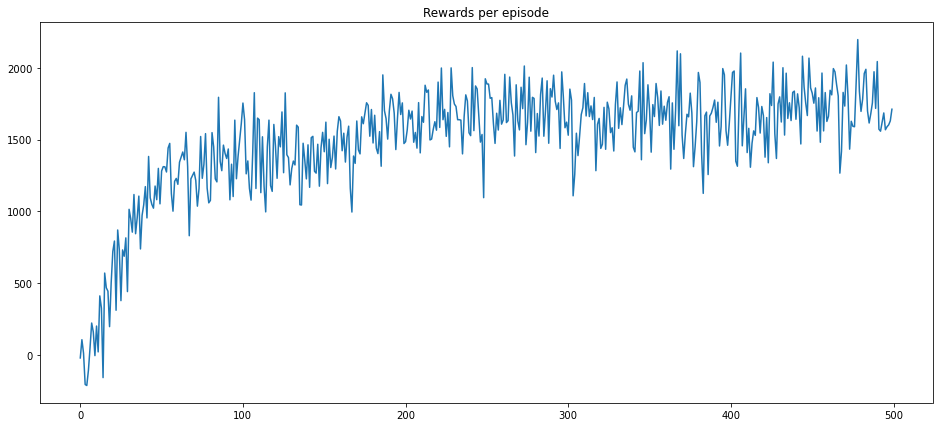

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()